In [13]:
from keras import backend as K
import numpy as np

In [2]:
from keras.applications.vgg16 import preprocess_input

In [3]:
from keras.preprocessing.image import load_img, img_to_array

In [4]:
targetHeight = 512
targetWidth = 512
targetSize = (targetHeight, targetWidth)

In [8]:
cImPath = 'image_data/cat.jpg'

In [16]:
sImPath = 'image_data/violin_and_palette.jpeg'

In [9]:
cImage = load_img(path=cImPath, target_size=targetSize)

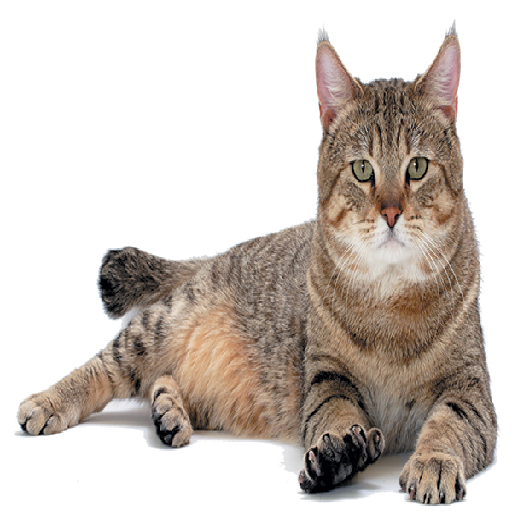

In [10]:
cImage

In [11]:
cImArr = img_to_array(cImage)

In [14]:
cImArr = K.variable(preprocess_input(np.expand_dims(cImArr, axis=0)), dtype='float32')

In [15]:
cImArr

<tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32_ref>

In [18]:
sImage = load_img(path=sImPath, target_size=targetSize)
sImArr = img_to_array(sImage)

In [21]:
sImage

In [19]:
sImArr = K.variable(preprocess_input(np.expand_dims(sImArr, axis=0)), dtype='float32')

In [22]:
gIm0 = np.random.randint(256, size=(targetWidth, targetHeight, 3)).astype('float64')

In [23]:
gIm0 = preprocess_input(np.expand_dims(gIm0, axis=0))

In [24]:
gImPlaceholder = K.placeholder(shape=(1, targetWidth, targetHeight, 3))

## Content Loss

In [25]:
def get_feature_reps(x, layer_names, model):
    """
    Get feature representations of input x for one or more layers in a given model.
    """
    featMatrices = []
    for ln in layer_names:
        selectedLayer = model.get_layer(ln)
        featRaw = selectedLayer.output
        featRawShape = K.shape(featRaw).eval(session=tf_session)
        N_l = featRawShape[-1]
        M_l = featRawShape[1]*featRawShape[2]
        featMatrix = K.reshape(featRaw, (M_l, N_l))
        featMatrix = K.transpose(featMatrix)
        featMatrices.append(featMatrix)
    return featMatrices

In [26]:
def get_content_loss(F, P):
    cLoss = 0.5*K.sum(K.square(F - P))
    return cLoss

In [27]:
def get_Gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G

In [28]:
def get_style_loss(ws, Gs, As):
    sLoss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_Gram_matrix(G)
        A_gram = get_Gram_matrix(A)
        sLoss+= w*0.25*K.sum(K.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return sLoss

In [58]:
def get_total_loss(gImPlaceholder, alpha=1.0, beta=10000.0):
    F = get_feature_reps(gImPlaceholder, layer_names=[cLayerName], model=gModel)[0]
    Gs = get_feature_reps(gImPlaceholder, layer_names=sLayerNames, model=gModel)
    contentLoss = get_content_loss(F, P)
    styleLoss = get_style_loss(ws, Gs, As)
    totalLoss = alpha*contentLoss + beta*styleLoss
    return totalLoss

In [59]:
def calculate_loss(gImArr):
    """
  Calculate total loss using K.function
  """
    if gImArr.shape != (1, targetWidth, targetWidth, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    loss_fcn = K.function([gModel.input], [get_total_loss(gModel.input)])
    return loss_fcn([gImArr])[0].astype('float64')

In [60]:
def get_grad(gImArr):
    """
      Calculate the gradient of the loss function with respect to the generated image
    """
    if gImArr.shape != (1, targetWidth, targetHeight, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    grad_fcn = K.function([gModel.input], 
                          K.gradients(get_total_loss(gModel.input), [gModel.input]))
    grad = grad_fcn([gImArr])[0].flatten().astype('float64')
    return grad

In [61]:
from keras.applications import VGG16
from scipy.optimize import fmin_l_bfgs_b

In [62]:
tf_session = K.get_session()

In [63]:
cModel = VGG16(include_top=False, weights='imagenet', input_tensor=cImArr)
sModel = VGG16(include_top=False, weights='imagenet', input_tensor=sImArr)
gModel = VGG16(include_top=False, weights='imagenet', input_tensor=gImPlaceholder)

In [64]:
cLayerName = 'block4_conv2'

In [65]:
sLayerNames = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                ]

In [66]:
P = get_feature_reps(x=cImArr, layer_names=[cLayerName], model=cModel)[0]
As = get_feature_reps(x=sImArr, layer_names=sLayerNames, model=sModel)
ws = np.ones(len(sLayerNames))/float(len(sLayerNames))

In [67]:
iterations = 1
x_val = gIm0.flatten()
xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, x_val, fprime=get_grad, maxiter=iterations, disp=True)

In [47]:
xopt

array([-92.09815231, -21.52090064,  70.51957466, ...,  90.56712118,
       128.90941292, 124.55146896])